In [58]:
import pandas as pd

# Load your data
df = pd.read_csv("../data/data.csv")
df



,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,24,Male,87.1,1.74,187,158,67,1.57,1364.0,Strength,10.0,3.5,4,3,28.77
969,25,Male,66.6,1.61,184,166,56,1.38,1260.0,Strength,25.0,3.0,2,1,25.69
970,59,Female,60.4,1.76,194,120,53,1.72,929.0,Cardio,18.8,2.7,5,3,19.50
971,32,Male,126.4,1.83,198,146,62,1.10,883.0,HIIT,28.2,2.1,3,2,37.74


In [59]:
df['Workout_Type'].value_counts()


Workout_Type
Strength    258
Cardio      255
Yoga        239
HIIT        221
Name: count, dtype: int64

In [60]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Workout_Type_Code'] = le.fit_transform(df['Workout_Type'])
#df['workout_type_code'].value_counts()
df = pd.get_dummies(df, columns=['Gender', 'Workout_Type', 'Experience_Level'], drop_first=True)
df['Workout_Type_Code'].value_counts()


Workout_Type_Code
2    258
0    255
3    239
1    221
Name: count, dtype: int64

In [61]:
X = df.drop('Calories_Burned', axis=1)
y = df['Calories_Burned']


<Axes: >

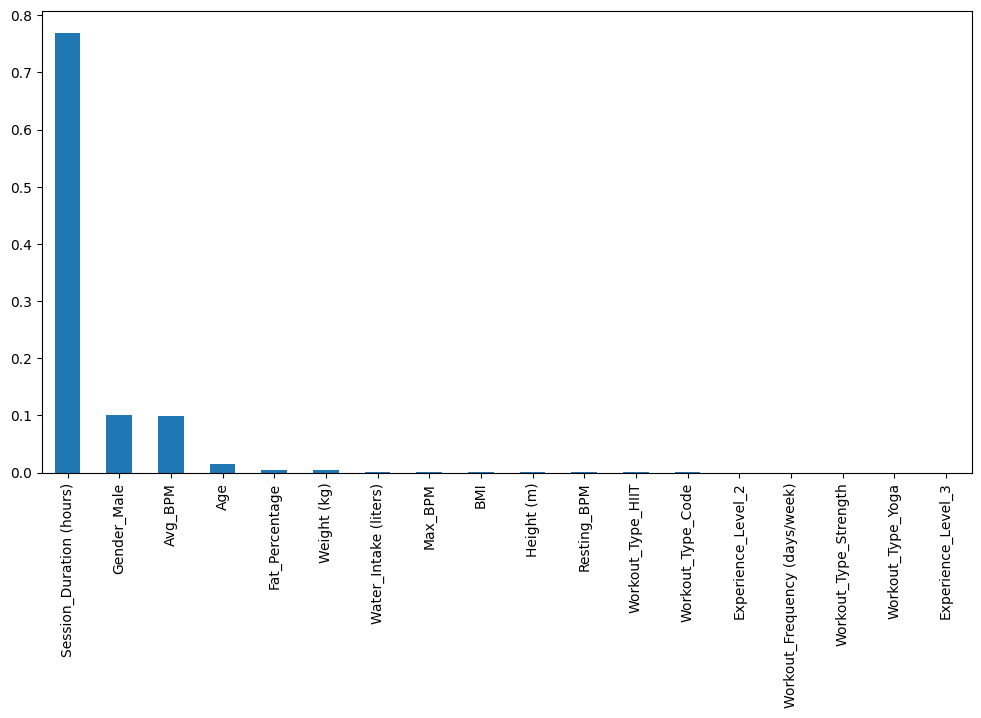

In [62]:
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel

model = XGBRegressor()
model.fit(X, y)

# Show feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))

In [63]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=5)
selector = selector.fit(X, y)

# Get top features
selected_features = X.columns[selector.support_]
print("Top selected features:", selected_features.tolist())


Top selected features: ['Height (m)', 'Avg_BPM', 'Session_Duration (hours)', 'Gender_Male', 'Workout_Type_Yoga']


In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error




# Identify all columns related to workout types
workout_columns = [col for col in df.columns if col.startswith('Workout_Type_')]
print("Workout type columns:", workout_columns)

# Selected features: Height, Avg_BPM, Session_Duration, Gender_Male + all workout types
#selected_features = ['Height (m)', 'Avg_BPM', 'Session_Duration (hours)', 'Gender_Male'] +workout_columns
selected_features = ['Height (m)', 'Avg_BPM', 'Session_Duration (hours)', 'Gender_Male','Workout_Type_Code']


# Features and target
X = df[selected_features]
y = df['Calories_Burned']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize model
model = RandomForestRegressor(random_state=42)

# Train model
model.fit(X_train, y_train)

# Training evaluation
y_train_pred = model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

# Testing evaluation
y_test_pred = model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

# Output
print(f"Training R² Score: {r2_train:.4f}")
print(f"Training MAE: {mae_train:.2f} calories")
print(f"Testing R² Score: {r2_test:.4f}")
print(f"Testing MAE: {mae_test:.2f} calories")
print(f"Cross-validated R² Score (mean of 5 folds): {cv_scores.mean():.4f}")


Workout type columns: ['Workout_Type_Code', 'Workout_Type_HIIT', 'Workout_Type_Strength', 'Workout_Type_Yoga']
Training R² Score: 0.9935
Training MAE: 17.74 calories
Testing R² Score: 0.9528
Testing MAE: 51.83 calories
Cross-validated R² Score (mean of 5 folds): 0.9526


In [65]:

mean_actual = y_test.mean()
accuracy = (1 - mae_test / mean_actual) * 100
print(f"Model Accuracy: {accuracy:.2f}%")


Model Accuracy: 94.31%


In [66]:
import joblib

# Save the model to a file
joblib.dump(model, '../models/calories_bruned_model.pkl')


['../models/calories_bruned_model.pkl']

In [ ]:
import pandas as pd
import joblib

# Load the trained model
model = joblib.load('cal.pkl')

# Get model features
model_features = list(model.feature_names_in_)

# Create 5 diverse test samples
test_samples = [
    {
        'Height (m)': 1.79,
        'Avg_BPM': 180,
        'Session_Duration (hours)': 1.5,
        'Gender_Male': 1,
        'Workout_Type_Code': 1
    },
    {
        'Height (m)': 1.75,
        'Avg_BPM': 145,
        'Session_Duration (hours)': 2,
        'Gender_Male': 1,
        'Workout_Type_Code': 1  
    },
    {
        'Height (m)': 1.82,
        'Avg_BPM': 110,
        'Session_Duration (hours)': 3,
        'Gender_Male': 1,
        'Workout_Type_Code': 2 
    },
    {
        'Height (m)': 1.60,
        'Avg_BPM': 125,
        'Session_Duration (hours)': 2.5,
        'Gender_Male': 0,
        'Workout_Type_Code': 3 
    },
    {
        'Height (m)': 1.90,
        'Avg_BPM': 150,
        'Session_Duration (hours)': 1,
        'Gender_Male': 1,
        'Workout_Type_Code': 2  
    }
]

# Predict for each sample
for i, sample in enumerate(test_samples, 1):
    # Start with all-zero features
    sample_full = {feat: 0 for feat in model_features}
    sample_full.update(sample)
    
    # Create DataFrame with correct column order
    df_sample = pd.DataFrame([sample_full])[model_features]
    
    # Make prediction
    prediction = model.predict(df_sample)[0]
    
    # Output result
    print(f"Sample {i} Prediction: {prediction:.2f} calories")




Sample 1 Prediction: 1292.37 calories
Sample 2 Prediction: 1426.36 calories
Sample 3 Prediction: 1122.50 calories
Sample 4 Prediction: 1161.93 calories
Sample 5 Prediction: 793.47 calories
